In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
# import sage
from math import comb
from scipy.stats import ttest_ind, t
from helper import *
from kernelshap import *

import sys
from os.path import join
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# df = sage.datasets.credit()
# df.to_csv("Data/credit.csv")
df = pd.read_csv("Data/credit.csv", index_col=0)

# Property, other installment, housing, job, status of checking act, credit history, purpose, savings, employment since, marital status, old debtors
n = df.shape[0]
X_df = df.drop(["Good Customer"], axis=1)
y = df["Good Customer"]

categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', #'Credit Amount', # It's listed but has 923 unique values
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', #'Telephone', 'Foreign Worker' # These are just binary
]
X_binarized = pd.get_dummies(X_df, columns=categorical_columns)

mapping_dict = {}
for i, col in enumerate(X_df.columns):
    bin_cols = []
    for j, bin_col in enumerate(X_binarized.columns):
        if bin_col.startswith(col):
            bin_cols.append(j)
    mapping_dict[i] = bin_cols

np.random.seed(1)
X_norm = (X_binarized-X_binarized.min())/(X_binarized.max()-X_binarized.min())
n_train = round(n*0.8)
train_idx = np.random.choice(n, n_train, replace=False)
X_train, y_train = X_norm.iloc[train_idx].to_numpy(), y.iloc[train_idx].to_numpy()
test_idx = np.setdiff1d(np.arange(n),train_idx)
X_test, y_test = X_norm.iloc[test_idx].to_numpy(), y.iloc[test_idx].to_numpy()
# d = X_train.shape[1] # dimension of binarized data

In [3]:
logreg = LogisticRegression().fit(X_train, y_train)
print("Class imbalance: {}".format(100*(max(np.mean(y_test), 1-np.mean(y_test)))))
print("Estimation accuracy: {}".format(np.mean((logreg.predict(X_test) > 0.5)==y_test)*100))

def fmodel(x):
    return logreg.predict_proba(x)[:,1]

# Compute mean and covariance of training data
feature_means = np.mean(X_train, axis=0)
cov_mat = correct_cov(np.cov(X_train, rowvar=False))

# Select point and compute its gradient and hessian
xloc = X_test[0:1]
BETA = logreg.coef_.reshape(-1)
y_pred = fmodel(xloc)
gradient = logreg_gradient(y_pred, BETA)
hessian = logreg_hessian(y_pred, BETA)

# Obtain true SHAP values and verify their feasibility
true_shap_vals = compute_shap_vals_quadratic(xloc, gradient, hessian, feature_means, cov_mat, mapping_dict=mapping_dict)

def model(input):
    return f_second_order_approx(y_pred,input,xloc,gradient,hessian)

Class imbalance: 72.0
Estimation accuracy: 74.0


In [9]:
%run kernelshap
np.random.seed(1)
K = 3
kshap_ests, kshap_vars, n_subsets = kernelshap(model, X_train, xloc, K, 
            n_perms_btwn_tests=50, n_samples_per_perm=50,
            mapping_dict=mapping_dict, K_thru_rest=False)
n_subsets

450

## FWER only controlled when n in t-test is # samples per perm, not # perms
Running w/ alpha=0.2 (expect up to 20% FWER)
- Using 20 samples per permutation, so it's probably not an issue of variance estimation
- Running 50x.

DF based on # of permutations (as we'd expect). 
- K=3: 35% FWER
- This is true with and without testing K vs K+1, K+2, .... So that doesn't really help.

DF based on # of samples per permutation (fewer --> wider distr --> harder to reject). 
- K=3: Now get 17% FWER :)

Problems with latter approach:

        - We know variance of SHAP values scales linearly with number of perms O(1/n). Here, it doesn't.
        - # samples per permutation is 1) Irrelevant for Bootstrapped variance, and 2) sometimes small. 
        - Not sure if it's theoretically justified...


Repeat with 50 samples per perm (still K=3):
- DF of # perms: 30% FWER
- DF of # samples per perm: 16% FWER

Repeat with 10 samples per perm (very, very slow):
- DF of # perms: 60% FWER
- DF of # samples per perm: Too slow but seemed to control FWER

In [136]:
%run kernelshap
np.random.seed(1)
K = 3
true_order = get_ordering(true_shap_vals)
true_top_K = true_order[:K]
print(true_top_K)
print("#"*20)
same_top_K = []
for i in range(50):
    kshap_ests, kshap_vars, n_subsets = kernelshap(model, X_train, xloc, K,
            n_perms_btwn_tests=100, n_samples_per_perm=10,
            mapping_dict=mapping_dict, K_thru_rest=False,
            alpha=0.2)
    est_top_K = np.argsort(np.abs(kshap_ests))[::-1][:K]

    has_same_top_K = np.array_equal(true_top_K, est_top_K)
    same_top_K.append(has_same_top_K)
    if (i+1) % 5==0: print(est_top_K, n_subsets, np.mean(same_top_K), i+1)
    
np.mean(same_top_K)

[19  2  0]
####################
[19  2  0] 400 0.2 5
[19  2  3] 200 0.4 10
[19  2  6] 200 0.4 15
[19  2  5] 300 0.35 20
[19  2  3] 400 0.36 25
[19  2  1] 100 0.4 30
[19  2  7] 200 0.37142857142857144 35
[19  2  0] 200 0.375 40
[19  2  3] 600 0.37777777777777777 45
[ 2 19  3] 200 0.38 50


0.38

## Examine distributions
### Distribution of KernelSHAP estimates
- Yes, it's Gaussian

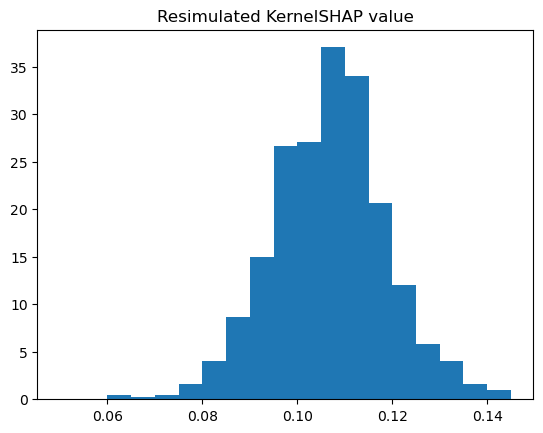

In [52]:
avg_pred = np.mean(model(X_train))
n_samples_per_perm = 10
n_subsets = 200
most_important_feat = get_ordering(kshap_ests)[0]
# kshaps = []
# for _ in range(1000):
#     coalitions, coalition_values, coalition_vars = compute_coalitions_values(model, X_train, xloc, 
#                                                                     n_subsets, n_samples_per_perm, 
#                                                                     mapping_dict)
#     kshap_ests = kshap_equation(y_pred, coalitions, coalition_values, avg_pred)
#     kshaps.append(kshap_ests[most_important_feat])
# np.save('Data/kshap_feat_1000x.npy', np.array(kshaps))

kshaps = np.load('Data/kshap_feat_1000x.npy')
plt.title("Resimulated KernelSHAP value")
plt.hist(kshaps, density=True, bins=np.arange(.05, .15, 0.005))
plt.show()

### Null distribution of t-statistic
We want to know whether the test statistic is t-distributed with some DF under the null that the SHAP values are the same.
- Earlier, we observed the tests rejected too often with large DF, but were fine with small DF

Procedure:
- Generate synthetic data with the mean and variance of our SHAP estimates
  - Generate {# perms} samples, since test statistic uses this many samples to compute sample variance
  
- For many iterations, randomly permute this data (i.e. assuming null is true) and compute its test statistics

        - Idk if this is valid. Permutation tests are valid when the two distributions are the same under the null. Here, though, they have the same mean but different variances.
        - Even if it is valid, idk whether to use permuted variances
- These test statistics are roughly t-distributed, with either a large or small DF

        - This seems to contradict our observations earlier. Not sure what to make of this.


895.0302095001521
16.14282942986246


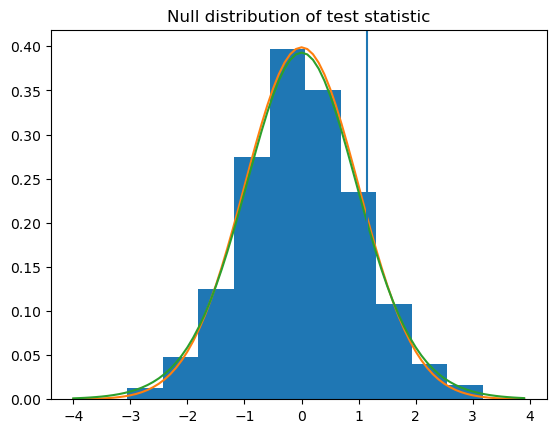

In [85]:
np.random.seed(1)
n_subsets = 500
coalitions, coalition_values, coalition_vars = compute_coalitions_values(model, X_train, xloc, 
                                                                n_subsets, n_samples_per_perm, 
                                                                mapping_dict)
kshap_ests = kshap_equation(y_pred, coalitions, coalition_values, avg_pred)
kshap_vars = compute_kshap_vars_ls(coalition_vars, coalitions)

order = get_ordering(kshap_ests)
first_test_to_fail = 0
feat1_idx = int(order[0])
feat2_idx = int(order[1])
shap1, shap2 = kshap_ests[feat1_idx], kshap_ests[feat2_idx]
var1, var2 = kshap_vars[feat1_idx], kshap_vars[feat2_idx]
if shap1*shap2 < 0:
    shap2 *= -1
# n_subsets = 10
test_stat = (shap1 - shap2)/np.sqrt(var1/n_subsets + var2/n_subsets)

# Randomly generate synthetic data - plausible SHAP values - with their mean and variance
n_samples = n_subsets
feat1_samples = np.random.normal(loc=shap1, scale=np.sqrt(var1), size=n_samples)
feat2_samples = np.random.normal(loc=shap2, scale=np.sqrt(var2), size=n_samples)
# Compute permuted test statistics on synthetic data
both = np.concatenate((feat1_samples, feat2_samples))
test_stats_perm = []
for _ in range(1000):
    random_order = np.random.choice(n_samples*2, size=n_samples*2, replace=False)
    feat1_perm = both[random_order[:n_samples]]
    feat2_perm = both[random_order[n_samples:]]
    shap1_perm, shap2_perm = np.mean(feat1_perm), np.mean(feat2_perm)
    # Not sure what to do about variance. 
    # var1_perm, var2_perm = np.var(feat1_perm, ddof=1), np.var(feat2_perm, ddof=1)
    # test_stat_perm = (shap1_perm - shap2_perm)/np.sqrt(var1_perm/n_subsets + var2_perm/n_subsets)
    test_stat_perm = (shap1_perm - shap2_perm)/np.sqrt(var1/n_subsets + var2/n_subsets)
    test_stats_perm.append(test_stat_perm)

xs = np.arange(-4, 4, 0.1)
df = (n_subsets-1)*(var1 + var2)**2 / (var1**2 + var2**2) # 
print(df)
ys = t.pdf(xs, df=df)

df2 = (n_samples_per_perm-1)*(var1 + var2)**2 / (var1**2 + var2**2) # Variance was calculated with n_samples_per_perm
print(df2)
ys2 = t.pdf(xs, df=df2)

plt.hist(test_stats_perm, density=True)
plt.plot(xs, ys)
plt.plot(xs, ys2)
plt.title("Null distribution of test statistic")
plt.axvline(test_stat)
plt.show()


# Redo with permutation test, not t-test

In [94]:
%run kernelshap
np.random.seed(1)
K = 3
kshap_ests, kshap_vars, n_subsets = kernelshap(model, X_train, xloc, K, 
            n_perms_btwn_tests=50, n_samples_per_perm=50,
            mapping_dict=mapping_dict, K_thru_rest=False, perm_test=True)
print(n_subsets)
print(get_ordering(true_shap_vals))
print(get_ordering(kshap_ests))

500
True


## Again, FWER only seems controlled using # samples per perm (confusing)
- alpha=0.2 --> Expect FWER ≤ 20%
- Here, make # samples per perm synthetic samples, with which to calculate permuted test stats

Running 50x w/ 20 samples/perm: 
- Number of sampled points is number of samples per perm: FWER is 15%
- Number of sampled points is number of subsets: FWER is 50%
- Number of sampled points is always 1000: FWER is 50%

Running 50x w/ 5 samples/perm (extremely slow): 
- Number of sampled points is number of samples per perm: 25% FWER


In [130]:
%run kernelshap
np.random.seed(1)
K = 3
true_order = get_ordering(true_shap_vals)
true_top_K = true_order[:K]
print(true_top_K)
print("#"*20)
same_top_K = []
for i in range(50):
    kshap_ests, kshap_vars, n_subsets = kernelshap(model, X_train, xloc, K,
            n_perms_btwn_tests=500, n_samples_per_perm=20,
            mapping_dict=mapping_dict, K_thru_rest=False, perm_test=True,
            alpha=0.2, n=20)
    est_top_K = np.argsort(np.abs(kshap_ests))[::-1][:K]

    has_same_top_K = np.array_equal(true_top_K, est_top_K)
    same_top_K.append(has_same_top_K)
    if (i+1) % 2==0: print(est_top_K, n_subsets, np.mean(same_top_K), i+1)
np.mean(same_top_K)

[19  2  0]
####################
[19  2  0] 1000 0.5 2
[19  2  3] 1500 0.25 4
[19  2  0] 3000 0.5 6


KeyboardInterrupt: 

## Redo using bootstrapped variance. Not as good. 
- alpha=0.2 --> Expect FWER ≤ 20%
- Running 50x w/ 5 samples/perm: 

### T-test: 
- Number of sampled points is number of subsets: FWER is 70%
- Number of sampled points is always 1000: FWER is 70%
- Number of sampled points is number of samples per perm: FWER is 40%

20 samples/perm (using): FWER is 35%

### Permutation test: 
- Number of sampled points is number of subsets: FWER is 55%
- Number of sampled points is always 1000: FWER is 50%
- Number of sampled points is number of samples per perm: FWER is 40%

20 samples/perm (using): FWER is 35%

In [139]:
%run kernelshap
np.random.seed(2)
K = 3
true_order = get_ordering(true_shap_vals)
true_top_K = true_order[:K]
print(true_top_K)
print("#"*20)
same_top_K = []
for i in range(50):
    kshap_ests, kshap_vars, n_subsets = kernelshap(model, X_train, xloc, K,
            n_perms_btwn_tests=500, n_samples_per_perm=20,
            mapping_dict=mapping_dict, K_thru_rest=False, perm_test=True,
            alpha=0.2, var_method="boot", n=20)
    est_top_K = np.argsort(np.abs(kshap_ests))[::-1][:K]

    has_same_top_K = np.array_equal(true_top_K, est_top_K)
    same_top_K.append(has_same_top_K)
    if (i+1) % 5==0: print(est_top_K, n_subsets, np.mean(same_top_K), i+1)

np.mean(same_top_K)

[19  2  0]
####################
[19  2  3] 500 0.6 5
[19  2  0] 500 0.6 10
[19  2  3] 500 0.6666666666666666 15
[19  2  0] 4000 0.7 20
[19  2  0] 500 0.72 25
[19  2  0] 1000 0.7 30
[19  2  3] 500 0.6571428571428571 35
[19  2  3] 500 0.625 40
[19  2  0] 1500 0.6444444444444445 45
[19  2  0] 1000 0.66 50


0.66